In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("../../data/raw/train.csv")
df

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,...,0,1,0,1,1,0,1,0,1,1
1,1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,...,1,1,0,1,1,0,1,0,1,1
2,2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,...,1,1,0,1,1,1,1,0,1,1
3,3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,...,0,0,0,0,1,0,1,0,1,1
4,4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,...,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,...,1,1,0,1,1,1,1,0,1,1
45528,45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,...,1,1,0,1,1,1,1,0,1,1
45529,45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,...,1,1,0,1,1,0,1,0,1,1
45530,45530,1.0,747,3.0,1331,4.0,892,2.0,1281,1.0,...,1,1,0,1,1,1,1,0,1,1


In [9]:
df.columns[]

SyntaxError: invalid syntax (2327340361.py, line 1)

In [10]:
df.value_counts(['voted'])
df.value_counts(['age_group'])

age_group
10s          14215
20s          14112
30s           7836
40s           5051
50s           2889
60s           1194
+70s           235
Name: count, dtype: int64

In [11]:
# 결측치 확인 (무응답을 결측치로 처리할 것인지? 생각해봐야할 것 같음)
df.isnull().sum()

index    0
QaA      0
QaE      0
QbA      0
QbE      0
        ..
wr_09    0
wr_10    0
wr_11    0
wr_12    0
wr_13    0
Length: 78, dtype: int64

-----------------

### 0. secreat 문항 삭제

In [12]:
# copy파일에서 삭제해줌 (원본X)
df_raw = df.copy()
secret_letters = ["a", "d", "g", "i", "l", "n", "p", "t"]

secret_cols = [
    c for c in df_raw.columns
    if (
        len(c) == 3 and
        c[0] == "Q" and
        c[2] in ["A", "E"] and
        c[1].lower() in secret_letters
    )
]
secret_cols


['QaA',
 'QaE',
 'QdA',
 'QdE',
 'QgA',
 'QgE',
 'QiA',
 'QiE',
 'QlA',
 'QlE',
 'QnA',
 'QnE',
 'QpA',
 'QpE',
 'QtA',
 'QtE']

In [13]:
# 제거한 파일
df_eda = df_raw.drop(columns=secret_cols).copy()

In [14]:
# voted 0/1로 변환 0: 비투표 1: 투표
df_eda["voted_bin"] = (df_eda["voted"] == 1).astype(int)
df_eda.value_counts(["voted_bin"])

voted_bin
0            24898
1            20634
Name: count, dtype: int64

-------------

1. Q_A 끼리 싹 묶어서 점수별 voted 차이 (1-5) 
2. Q_E 끼리 묶어서 시간별 voted 차이 (얘는 초 단위인지 반응속도인지 모르겠지만 범위가 넓음) 
3. tp 문항 점수대별 voted 
4. 배경/사회 인구통계 별 voted
5. 단어 아는지 여부 별 voted


-------------------

## 1. Q_A(심리 설문 응답) 1–5 점수대별 voting rate 차이

In [15]:
# 1. Q_A만 select
qa_cols = [c for c in df_eda.columns if c.endswith("A")]
len(qa_cols), qa_cols

(12,
 ['QbA',
  'QcA',
  'QeA',
  'QfA',
  'QhA',
  'QjA',
  'QkA',
  'QmA',
  'QoA',
  'QqA',
  'QrA',
  'QsA'])

In [16]:
# 2. long 형태로 만들기
qa_long = df_eda.melt(
    id_vars=["voted_bin"],
    value_vars=qa_cols,
    var_name="question",
    value_name="score"
)

In [17]:
# 3. 문항 × 점수(1~5)별 투표율 계산
qa_summary = (
    qa_long
    .groupby(["question", "score"])
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
    .sort_values(["question", "score"])
)

qa_summary.head(10)

,question,score,voted_rate,n
0,QbA,1.0,0.512102,13427
1,QbA,2.0,0.477905,7830
2,QbA,3.0,0.438796,4052
3,QbA,4.0,0.442544,10112
4,QbA,5.0,0.372169,10111
5,QcA,1.0,0.500258,5809
6,QcA,2.0,0.471677,6161
7,QcA,3.0,0.429366,3596
8,QcA,4.0,0.469862,11995
9,QcA,5.0,0.425241,17971


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

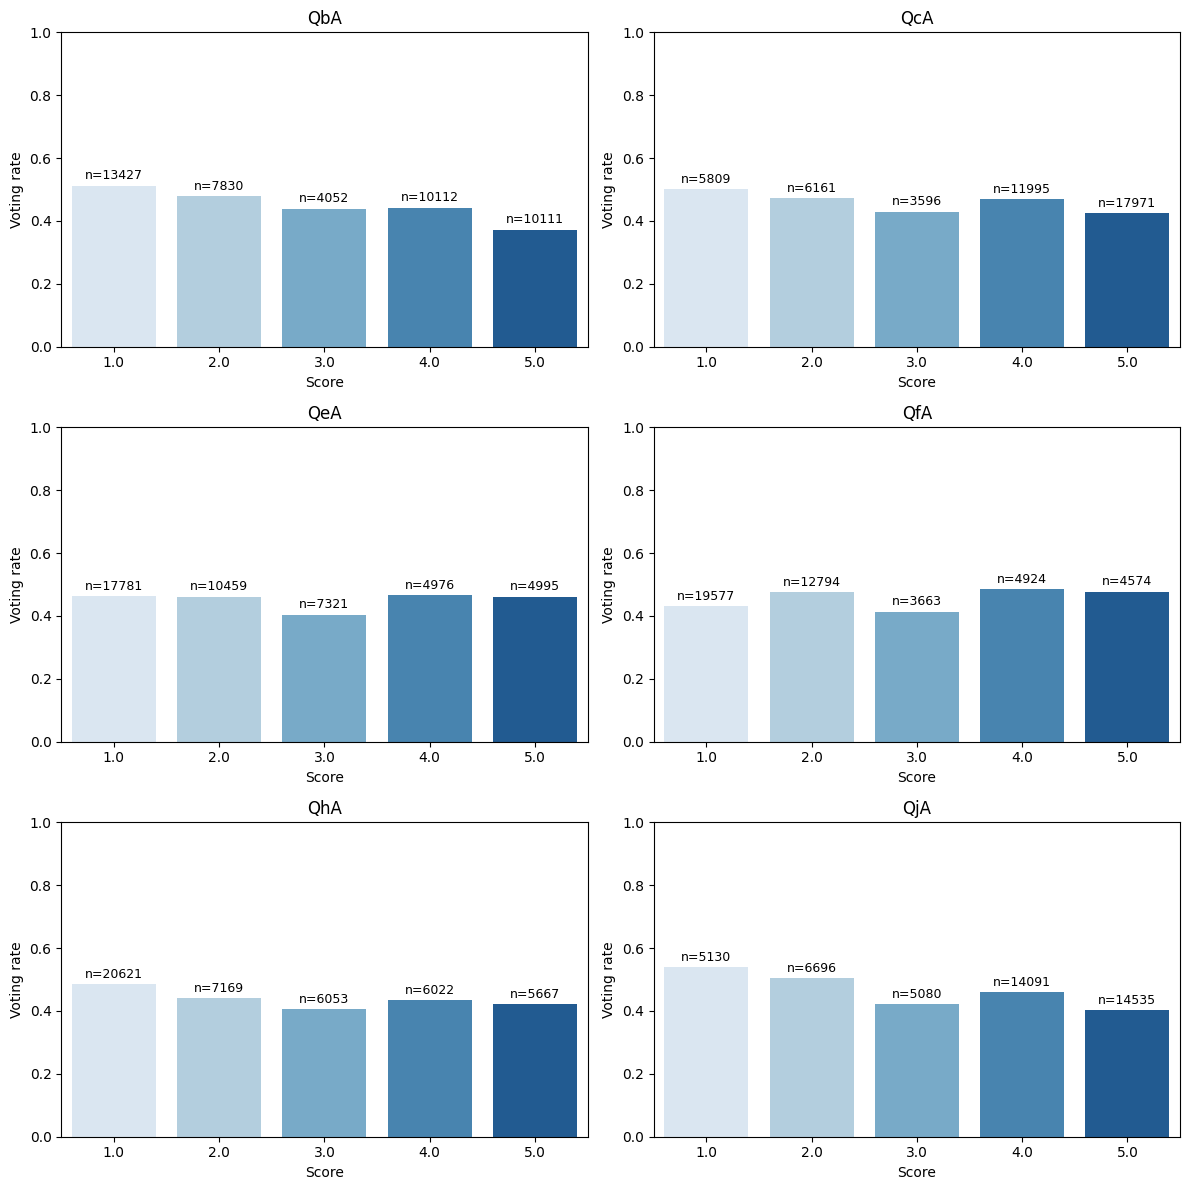

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_37515/1282465440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

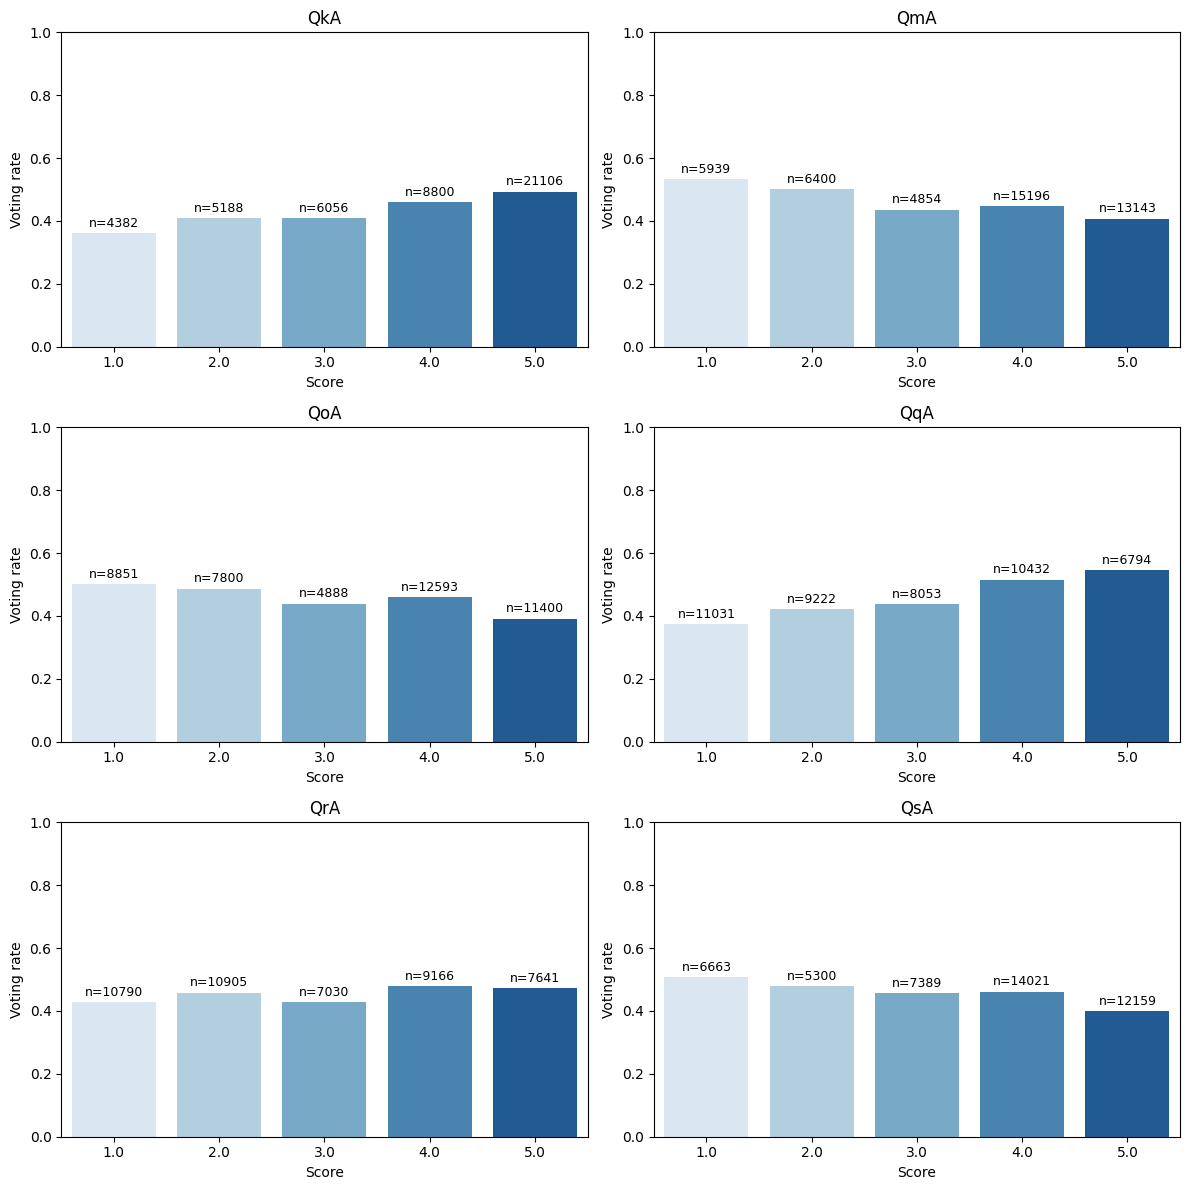

In [18]:
# 4. 문항 6개씩 묶어서 bar plot으로 확인 (voting rate 기준)
qa_unique = sorted(qa_summary["question"].unique())
chunks = [qa_unique[i:i+6] for i in range(0, len(qa_unique), 6)]

for chunk in chunks:
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()

    for ax, q in zip(axes, chunk):
        sub = qa_summary[qa_summary["question"] == q]

        sns.barplot(
            data=sub,
            x="score",
            y="voted_rate",
            ax=ax,
            palette="Blues"
        )

        ax.set_title(q)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Score")
        ax.set_ylabel("Voting rate")

        # n 값 bar 위에 표시
        for i, row in sub.iterrows():
            ax.text(
                row["score"] - 1,
                row["voted_rate"] + 0.02,
                f'n={int(row["n"])}',
                ha='center',
                fontsize=9
            )

    # 남는 subplot 제거
    for j in range(len(chunk), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

QbA: 범죄자와 일반인의 가장 큰 차이는 그들이 잡힐 정도로 멍청하다는 것이다.
(냉소적 세계관, 제도 불신)
→ 동의할수록 투표율이 낮아지는 경향

QcA: 타인을 완전히 신뢰하는 사람은 스스로 화를 자초하는 것이다.
(대인 불신, 경계적 태도)
→ 동의할수록 투표율이 낮아지는 경향

QeA: “매순간 속기 위해 태어나는 자가 있다”는 바넘의 말은 틀렸다.
(판단 유보, 중도적 태도)
→ 중간 점수(3점)에서 투표율이 가장 낮게 나타남

QfA: 타인에게 거짓말을 하는 것에는 어떤 변명도 통하지 않는다.
(도덕 규범 중시, 윤리적 태도)
→ 중간 점수(3점)에서 투표율이 가장 낮게 나타남

QhA: 부모의 죽음보다 재산을 잃는 것을 더 쉽게 잊는다.
(물질 중심 인식, 감정 둔감)
→ 동의하지 않을수록 투표율이 높게 나타남

QjA: 모든 사람에게는 기회만 주어지면 드러날 악한 본성이 있다고 가정하는 것이 안전하다.
(인간 불신, 경계적 현실 인식)
→ 동의하지 않을수록 투표율이 높게 나타남

QkA: 중요하고 부정직한 사람보다 겸손하고 정직한 사람이 되는 것이 낫다.
(도덕성 중시, 시민 규범 의식)
→ 동의할수록 투표율이 명확히 증가

QmA: 편법(지름길)을 쓰지 않고 앞서가기란 어렵다.
(현실주의, 규범 회피)
→ 동의할수록 투표율이 낮아지는 경향

QoA: 사람을 다루는 가장 좋은 방법은 그들이 듣고 싶어 하는 말을 하는 것이다.
(기회주의, 조작적 대인관계)
→ 전반적으로 투표율이 낮으며, 동의 시 감소

QqA: 대부분의 사람은 기본적으로 선하고 친절하다.
(사회적 신뢰, 공동체 의식)
→ 동의할수록 투표율이 높아지는 경향

QrA: 도덕적으로 옳다는 확신이 들 때만 행동해야 한다.
(도덕적 확신, 신중한 행동성)
→ 강한 동의(4–5점) 구간에서 투표율이 소폭 증가

QsA: 중요한 사람들에게 아부하는 것은 현명한 일이다.
(권력 지향, 기회주의)
→ 강한 동의 시 투표율이 급격히 감소



### Q_A 해석 → Feature 설계 연결

- **부정 태도 문항 (`neg_att`)**  
  b, c, j, m, o, s  
  → 동의할수록 투표율 ↓  
  → 냉소·불신·규범 회피·기회주의 성향  
  → 평균값으로 하나의 태도 점수로 요약

- **긍정 태도 문항 (`pos_att`)**  
  k, q  
  → 동의할수록 투표율 ↑  
  → 도덕성·사회적 신뢰·시민 규범 의식  
  → 평균값으로 하나의 태도 점수로 요약

- **기타 문항 (확신도 기반 해석)**  
  e, f, h, r 등  
  → 3점(중도)에서 투표율 최저  
  → 1–2, 4–5 간 투표율 차이는 크지 않음  
  → 태도 방향보다 ‘확신 여부’가 중요

### Feature 구성 요약
- `neg_att` : 부정 태도 평균 점수  
- `pos_att` : 긍정 태도 평균 점수  
- `confident_ratio` : 1–2 또는 4–5 응답 비율 (확신도)  
- `neutral_ratio` : 3점 응답 비율 (중도/무관심)



-------------------------------------------------------------------------------------------------------------

## 2. Q_E (반응시간)

In [19]:
df_eda.filter(regex="E$").describe().T

,count,mean,std,min,25%,50%,75%,max
QbE,45532.0,2189.588575,33510.265924,25.0,875.0,1218.0,1838.0,5580395.0
QcE,45532.0,1484.294518,8977.664318,25.0,651.0,899.0,1335.0,871557.0
QeE,45532.0,1899.292278,16707.654162,25.0,834.0,1154.0,1656.0,1919926.0
QfE,45532.0,1850.650268,76082.355454,25.0,504.0,712.0,1078.0,11763701.0
QhE,45532.0,4584.272138,502026.451770,0.0,1077.0,1464.0,2090.0,107086013.0
QjE,45532.0,2576.362910,54114.316008,0.0,902.0,1260.0,1899.0,9910006.0
QkE,45532.0,2038.985790,30691.644500,0.0,859.0,1178.0,1721.0,4824953.0
QmE,45532.0,2050.286524,75307.865175,25.0,650.0,906.0,1342.0,14108320.0
QoE,45532.0,1435.761662,10849.973342,0.0,638.0,883.0,1300.0,1309739.0
QqE,45532.0,1154.351665,22506.885924,0.0,461.0,652.0,982.0,4277510.0


In [20]:
# 1. Q_E (반응시간) 컬럼만 추출
qe_cols = [c for c in df_eda.columns if c.endswith("E")]

print(len(qe_cols))
print(qe_cols)


12
['QbE', 'QcE', 'QeE', 'QfE', 'QhE', 'QjE', 'QkE', 'QmE', 'QoE', 'QqE', 'QrE', 'QsE']


In [21]:
# 2. 극단치 처리 (상위 1% 컷)
qe = df_eda[qe_cols].copy()

for c in qe_cols:
    upper = qe[c].quantile(0.99)
    qe[c] = qe[c].clip(upper=upper)

In [22]:
# 3. log 변환 (분포 안정화)
qe_log = np.log1p(qe)

In [23]:
# 4. 개인별 반응시간 요약 feature
df_eda["rt_mean"] = qe_log.mean(axis=1)  # 전반적 망설임 정도
df_eda["rt_std"]  = qe_log.std(axis=1)   # 문항 간 응답 일관성

In [ ]:
# 5. 투표 여부별 평균 반응시간 비교
rt_by_vote = (
    df_eda
    .groupby("voted_bin")["rt_mean"]
    .agg(["mean", "median", "count"])
)

print(rt_by_vote)

               mean    median  count
voted_bin                           
0          6.939052  6.912919  24898
1          6.986588  6.966351  20634


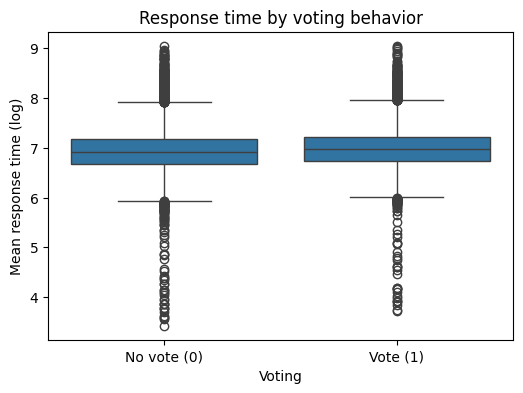

In [ ]:
# 6. 분포 시각화 (boxplot)
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="voted_bin",
    y="rt_mean",
    data=df_eda
)
plt.xticks([0, 1], ["No vote (0)", "Vote (1)"])
plt.xlabel("Voting")
plt.ylabel("Mean response time (log)")
plt.title("Response time by voting behavior")
plt.show()

Q_E는 단독으로는 신호가 약하고, 확신도·무관심 지표가 정의된 이후에 보조 feature로 활용할 지 말지 봐야할 듯

---------

## 3. TP(성격 Big Five) voting rate 차이
성격 5요인(Big Five) 검사는 인간의 성격을 개방성(Openness), 성실성(Conscientiousness), 외향성(Extraversion), 친화성(Agreeableness), 신경성(Neuroticism)의 다섯 가지 핵심 요소로 측정하는 대표적인 성격 이론

정방향 문항 점수에서 역방향 문항 점수를 차감(긍정 − 부정)

외향성 = tp01 − tp06

성실성 = tp03 − tp08

신경성 = tp04 − tp09

개방성 = tp05 − tp10

친화성 = tp07 − tp02


차이값은 대략 -6 ~ +6 사이


In [ ]:
# 1. TP 성향 점수 만들기
df_tp = df_eda.copy()

df_tp["extraversion"] = df_tp["tp01"] - df_tp["tp06"]
df_tp["conscientiousness"] = df_tp["tp03"] - df_tp["tp08"]
df_tp["neuroticism"] = df_tp["tp04"] - df_tp["tp09"]
df_tp["openness"] = df_tp["tp05"] - df_tp["tp10"]
df_tp["agreeableness"] = df_tp["tp07"] - df_tp["tp02"]

In [ ]:
# 2. 3단계로 Binning (±2 기준)
def bin_trait(x):
    if x <= -2:
        return "Low"
    elif x >= 2:
        return "High"
    else:
        return "Mid"
    
trait_cols = [
    "extraversion",
    "agreeableness",
    "conscientiousness",
    "neuroticism",
    "openness"
]

for col in trait_cols:
    df_tp[f"{col}_bin"] = df_tp[col].apply(bin_trait)


In [ ]:
# 3. 투표율 요약 테이블 만들고 시각화
tp_pair_summary = (
    df_tp
    .melt(
        id_vars="voted_bin",
        value_vars=[f"{c}_bin" for c in trait_cols],
        var_name="trait",
        value_name="level"
    )
    .groupby(["trait", "level"])
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
)

tp_pair_summary


,trait,level,voted_rate,n
0,agreeableness_bin,High,0.391698,10503
1,agreeableness_bin,Low,0.496525,16690
2,agreeableness_bin,Mid,0.448934,18339
3,conscientiousness_bin,High,0.377090,7176
4,conscientiousness_bin,Low,0.495164,24709
5,conscientiousness_bin,Mid,0.417161,13647
6,extraversion_bin,High,0.433227,19484
7,extraversion_bin,Low,0.489442,13544
8,extraversion_bin,Mid,0.444978,12504
9,neuroticism_bin,High,0.487694,19422


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/4066697508.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


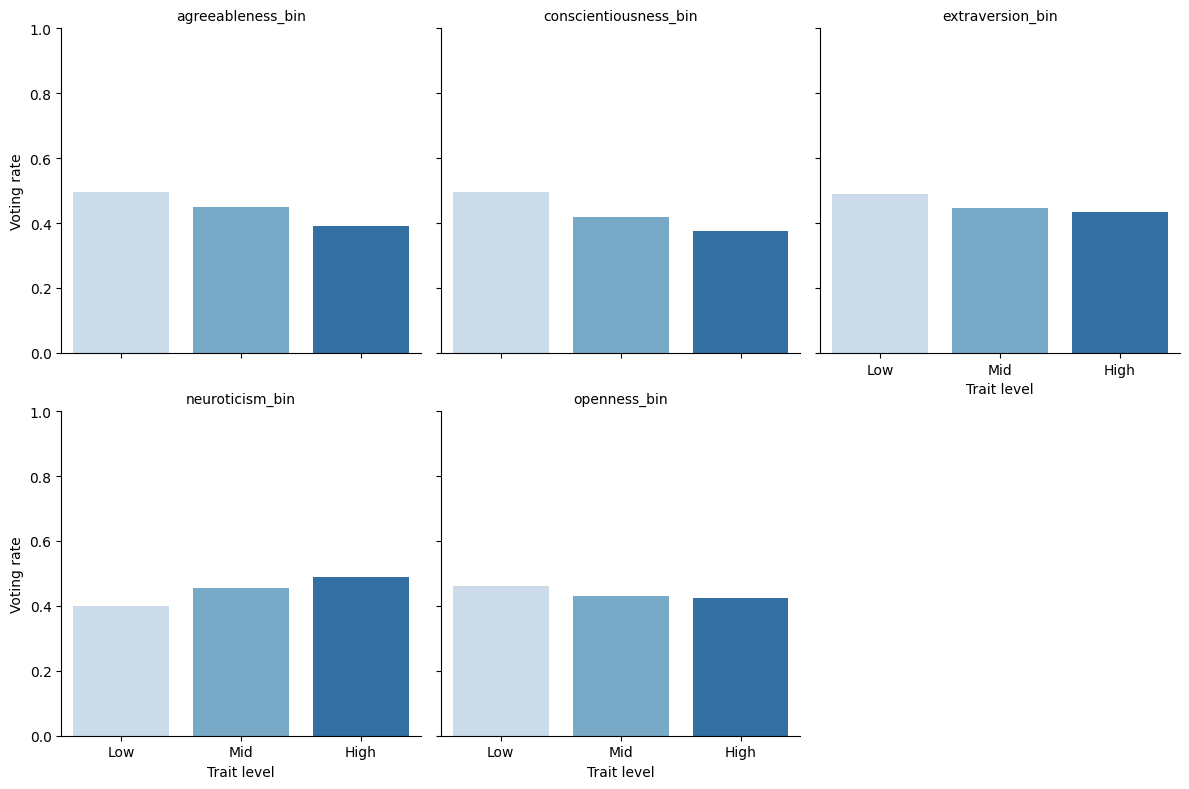

In [ ]:
# 시각화
g = sns.catplot(
    data=tp_pair_summary,
    x="level",
    y="voted_rate",
    col="trait",
    kind="bar",
    col_wrap=3,
    height=4,
    aspect=1,
    order=["Low", "Mid", "High"],
    palette="Blues"
)

g.set_axis_labels("Trait level", "Voting rate")
g.set_titles("{col_name}")
g.set(ylim=(0, 1))

plt.tight_layout()
plt.show()


--------------

### 3-1. ±2 / ±4 차이 비교

완화된 기준(±2)

엄격한 기준(±4)

In [ ]:
traits = [
    "openness",
    "conscientiousness",
    "extraversion",
    "agreeableness",
    "neuroticism"
]

def bin_trait_2(x):
    if x <= -2:
        return "Low"
    elif x >= 2:
        return "High"
    else:
        return "Mid"

def bin_trait_4(x):
    if x <= -4:
        return "Low"
    elif x >= 4:
        return "High"
    else:
        return "Mid"

In [ ]:
rows = []

for trait in traits:
    for cutoff, func in [("±2", bin_trait_2), ("±4", bin_trait_4)]:
        tmp = df_tp[[trait, "voted_bin"]].copy()
        tmp["level"] = tmp[trait].apply(func)
        tmp["trait"] = trait
        tmp["cutoff"] = cutoff
        rows.append(tmp)

compare_df = pd.concat(rows)


In [ ]:
summary_compare = (
    compare_df
    .groupby(["trait", "cutoff", "level"])
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
)

summary_compare


,trait,cutoff,level,voted_rate,n
0,agreeableness,±2,High,0.391698,10503
1,agreeableness,±2,Low,0.496525,16690
2,agreeableness,±2,Mid,0.448934,18339
3,agreeableness,±4,High,0.364348,4342
4,agreeableness,±4,Low,0.527572,8505
5,agreeableness,±4,Mid,0.445617,32685
6,conscientiousness,±2,High,0.377090,7176
7,conscientiousness,±2,Low,0.495164,24709
8,conscientiousness,±2,Mid,0.417161,13647
9,conscientiousness,±4,High,0.359900,2798


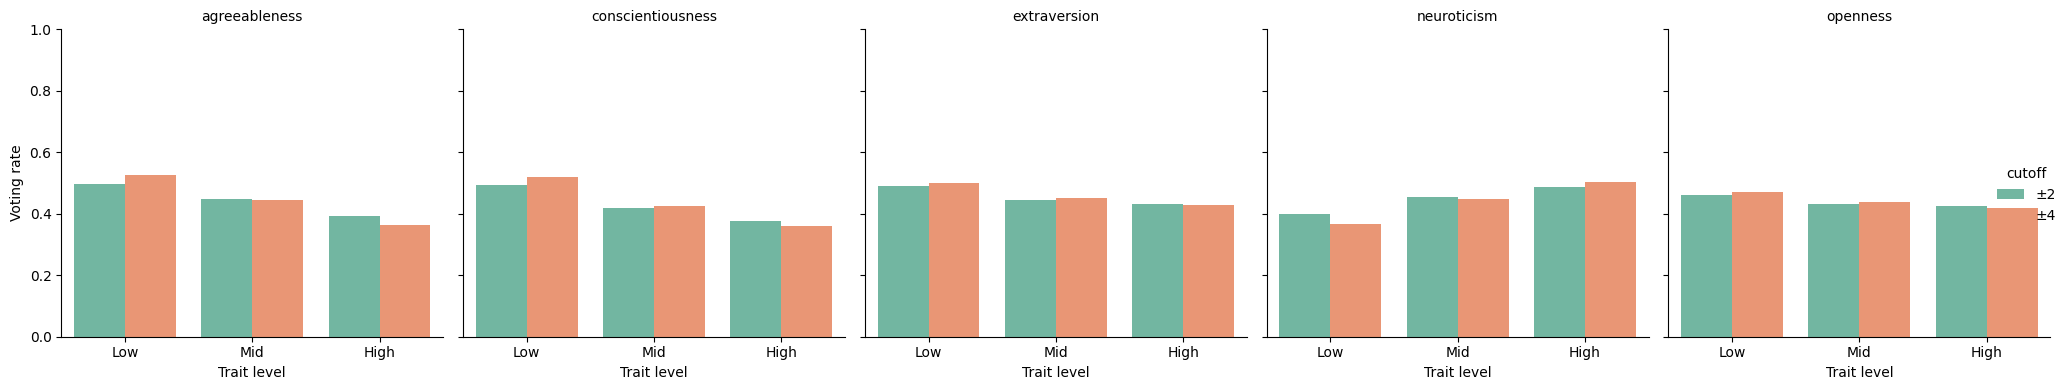

In [ ]:
g = sns.catplot(
    data=summary_compare,
    x="level",
    y="voted_rate",
    hue="cutoff",
    col="trait",
    kind="bar",
    order=["Low", "Mid", "High"],
    height=4,
    aspect=1,
    palette="Set2"
)

g.set_axis_labels("Trait level", "Voting rate")
g.set_titles("{col_name}")
g.set(ylim=(0, 1))

plt.tight_layout()
plt.show()


TP 문항은 1–7 리커트 척도

두 문항 간 차이가 1 이내인 경우, 응답 오차·상황 요인에 의한 변동일 가능성이 큼

차이가 2 이상일 때, 일관된 성향 차이로 해석 가능

따라서 ±2는 성향이 있다고 판단할 수 있는 최소 기준선으로 설정 = ±4는 비교적 극단적인 기준 때문에 mid로 sample이 많이 빠질 것 같음 

이 부분 결론 !
1. TP 5가지 성향 점수 만들기 + ±2를 성향이 있다고 판단할 수 있는 최소 기준선으로 설정

2. 모델 학습에 사용 -> Big Five 성향 점수(diff) 및 확신도(|diff|)

diff만 쓰면 → 방향은 알지만 얼마나 강한지가 약함

|diff|만 쓰면 → 강도는 알지만 어느 쪽인지를 모름

-----------------

## 4. 배경/사회인구통계 별 voting rate 차이

#### 1. age_group

In [ ]:
# 1. 결측/이상치 확인
df_eda["age_group"].value_counts(dropna=False)

age_group
10s     14215
20s     14112
30s      7836
40s      5051
50s      2889
60s      1194
+70s      235
Name: count, dtype: int64

In [ ]:
# 2. age_group별 투표율 테이블
age_summary = (
    df_eda
    .groupby("age_group")
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
)

# 연령대 순서 정렬
order = ["10s","20s","30s","40s","50s","60s","+70s"]
age_summary["age_group"] = pd.Categorical(age_summary["age_group"], categories=order, ordered=True)
age_summary = age_summary.sort_values("age_group")

age_summary

,age_group,voted_rate,n
1,10s,0.162786,14215
2,20s,0.530329,14112
3,30s,0.588821,7836
4,40s,0.642051,5051
5,50s,0.670128,2889
6,60s,0.728643,1194
0,+70s,0.736170,235


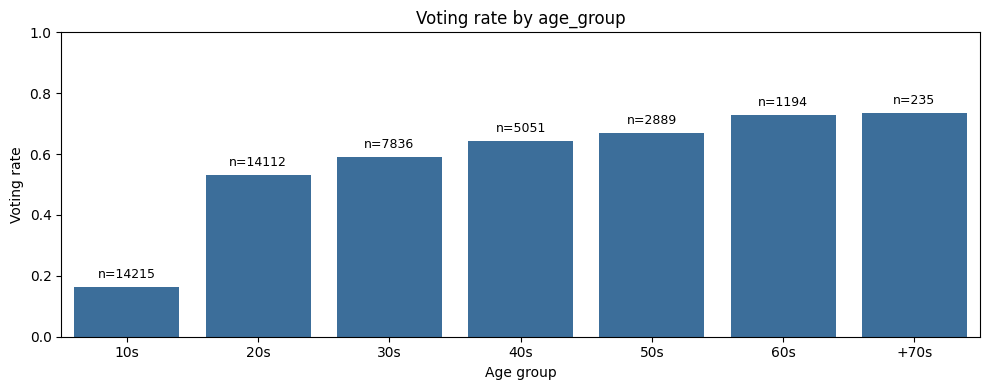

In [ ]:
# 3. 그래프로 확인
plt.figure(figsize=(10,4))
ax = sns.barplot(
    data=age_summary,
    x="age_group",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Age group")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by age_group")

# 막대(patch) 기준으로 n 표시
for patch, (_, row) in zip(ax.patches, age_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,  # 막대 중앙
        height + 0.02,                           # 막대 끝 바로 위
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9,
        color="black"
    )

plt.tight_layout()
plt.show()


In [ ]:
# 4. 차이가 유의미 한지
# 전체 평균 투표율
overall_rate = df_eda["voted_bin"].mean()

# 각 연령대의 투표율이 전체 평균에서 얼마나 벗어나는지(절대차)
age_summary["delta_vs_overall"] = (age_summary["voted_rate"] - overall_rate).abs()

overall_rate, age_summary[["age_group","voted_rate","n","delta_vs_overall"]]


(np.float64(0.45317578845647016),
   age_group  voted_rate      n  delta_vs_overall
 1       10s    0.162786  14215          0.290390
 2       20s    0.530329  14112          0.077153
 3       30s    0.588821   7836          0.135645
 4       40s    0.642051   5051          0.188875
 5       50s    0.670128   2889          0.216952
 6       60s    0.728643   1194          0.275467
 0      +70s    0.736170    235          0.282994)

##### age_group: 연령대가 증가할수록 투표율 증가 !

#### 2. education
1 : 고졸 미만

2 : 고졸

3 : 대졸

4 : 대학원

In [ ]:
# 1. 무응답 제거 및 분포 확인
df_eda["education_clean"] = df_eda["education"].replace(0, np.nan)

df_eda["education_clean"].value_counts(dropna=False)


education_clean
2.0    16835
3.0    15227
4.0     7854
1.0     5088
NaN      528
Name: count, dtype: int64

In [ ]:
# 2. education 별 "투표율 테이블 
edu_summary = (
    df_eda
    .groupby("education_clean")
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
    .sort_values("education_clean")
)

# 전체 평균 대비 차이
overall_rate = df_eda["voted_bin"].mean()
edu_summary["delta_vs_overall"] = edu_summary["voted_rate"] - overall_rate

edu_summary


,education_clean,voted_rate,n,delta_vs_overall
0,1.0,0.049725,5088,-0.403451
1,2.0,0.367033,16835,-0.086143
2,3.0,0.596506,15227,0.143330
3,4.0,0.619684,7854,0.166508


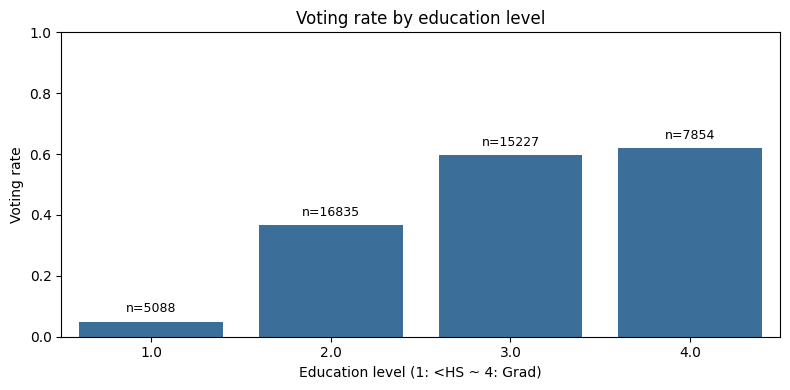

In [ ]:
# 3. 시각화
plt.figure(figsize=(8,4))
ax = sns.barplot(
    data=edu_summary,
    x="education_clean",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Education level (1: <HS ~ 4: Grad)")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by education level")

# bar 끝 기준으로 n 표시
for patch, (_, row) in zip(ax.patches, edu_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


##### education: 학력 수준 높아질수록 투표율 증가 !

#### 3. engnat(영어 모국어 여부)
1 = Yes (영어 모국어)

2 = No (비모국어)

In [ ]:
# 1. 무응답 제거 및 분포 확인
df_eda["engnat_clean"] = df_eda["engnat"].replace(0, np.nan)

df_eda["engnat_clean"].value_counts(dropna=False)

engnat_clean
1.0    33024
2.0    12431
NaN       77
Name: count, dtype: int64

In [ ]:
# 2. engnet별 투표율 테이블
engnat_summary = (
    df_eda
    .groupby("engnat_clean")
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
    .sort_values("engnat_clean")
)

overall_rate = df_eda["voted_bin"].mean()
engnat_summary["delta_vs_overall"] = engnat_summary["voted_rate"] - overall_rate

engnat_summary


,engnat_clean,voted_rate,n,delta_vs_overall
0,1.0,0.462603,33024,0.009427
1,2.0,0.428606,12431,-0.024570


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/2193735676.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Yes", "No"])


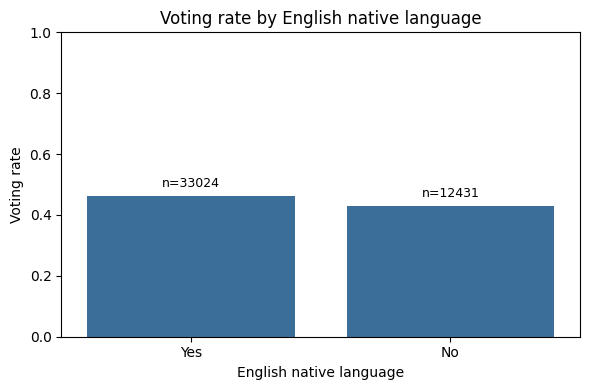

In [ ]:
# 3. 시각화
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=engnat_summary,
    x="engnat_clean",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("English native language")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by English native language")

ax.set_xticklabels(["Yes", "No"])

for patch, (_, row) in zip(ax.patches, engnat_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


##### engnet: 크게 차이 없어 보임

#### 4. familysize

In [ ]:
# 1. 분포 확인
df_eda["familysize"].describe()
df_eda["familysize"].value_counts()

familysize
2             17918
3             11256
1              6535
4              4907
5              1962
0              1217
6               838
7               387
8               221
9               126
10               59
11               39
12               21
13               11
14                9
15                8
44                3
17                3
21                2
20                2
16                2
999               1
2147483647        1
100               1
34                1
30                1
18                1
Name: count, dtype: int64

In [ ]:
# 2. 너무 큰 값 제거 (여기서는 12이상 제거함)
df_eda["familysize_clean"] = df_eda["familysize"]

df_eda.loc[df_eda["familysize_clean"] > 12, "familysize_clean"] = np.nan

# 구간화
df_eda["familysize_bin"] = pd.cut(
    df_eda["familysize"],
    bins=[-1, 0, 1, 2, 3, 5, 12],
    labels=["0", "1", "2", "3", "4-5", "6-12"]
)

In [ ]:
# 3. familysize 요약 테이블
fam_summary = (
    df_eda
    .groupby("familysize_bin")
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
)

# 전체 평균 대비 차이
overall_rate = df_eda["voted_bin"].mean()
fam_summary["delta_vs_overall"] = fam_summary["voted_rate"] - overall_rate

fam_summary

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/2351336177.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("familysize_bin")


,familysize_bin,voted_rate,n,delta_vs_overall
0,0,0.413311,1217,-0.039864
1,1,0.424331,6535,-0.028845
2,2,0.450106,17918,-0.003070
3,3,0.456912,11256,0.003736
4,4-5,0.482894,6869,0.029718
5,6-12,0.477824,1691,0.024648


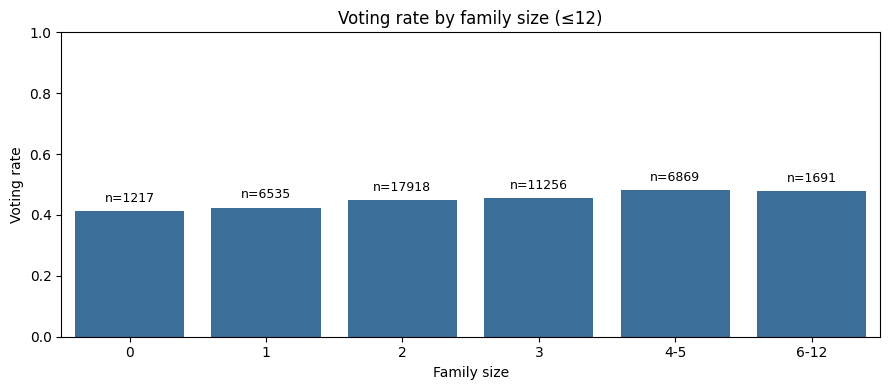

In [ ]:
# 4. 시각화
plt.figure(figsize=(9,4))
ax = sns.barplot(
    data=fam_summary,
    x="familysize_bin",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Family size")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by family size (≤12)")

# 막대 끝 기준 n 표시
for patch, (_, row) in zip(ax.patches, fam_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

##### familysize: 크게 차이 없어 보임

#### 5. gender

In [ ]:
# 1. 분포 확인
df_eda["gender"].value_counts(dropna=False)

gender
Male      24217
Female    21315
Name: count, dtype: int64

In [ ]:
# 2. gender 투표율 요약 테이블
gender_summary = (
    df_eda
    .groupby("gender")
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
)

overall_rate = df_eda["voted_bin"].mean()
gender_summary["delta_vs_overall"] = gender_summary["voted_rate"] - overall_rate

gender_summary

,gender,voted_rate,n,delta_vs_overall
0,Female,0.460427,21315,0.007251
1,Male,0.446794,24217,-0.006382


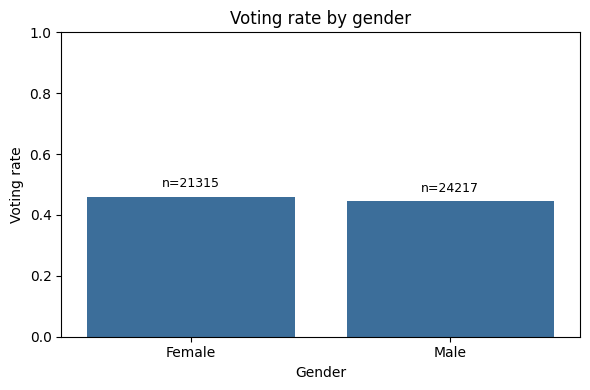

In [ ]:
# 3. 시각화
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=gender_summary,
    x="gender",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Gender")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by gender")

# 막대 끝 기준 n 표시
for patch, (_, row) in zip(ax.patches, gender_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


##### gender: 크게 차이 없어 보임

#### 6. hand
1: 우 / 2: 좌 / 3: 양손 / 0: 무응답

In [ ]:
# 1. 전처리 (무응답)
df_eda["hand_clean"] = df_eda["hand"].replace(0, np.nan)

In [ ]:
# 2. hand 요약 테이블
hand_summary = (
    df_eda
    .groupby("hand_clean")
    .agg(voted_rate=("voted_bin","mean"), n=("voted_bin","size"))
    .reset_index()
)
hand_summary


,hand_clean,voted_rate,n
0,1.0,0.454683,39058
1,2.0,0.459506,4692
2,3.0,0.407156,1621


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/1675719574.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Right", "Left", "Both"])


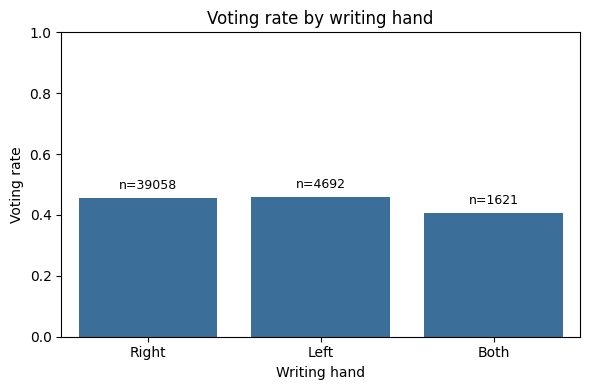

In [ ]:
# 3. 시각화
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=hand_summary,
    x="hand_clean",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Writing hand")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by writing hand")

# x축 라벨 정리 (가독성 중요)
ax.set_xticklabels(["Right", "Left", "Both"])

# 막대 끝 기준 n 표시
for patch, (_, row) in zip(ax.patches, hand_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


##### hand: 크게 차이 없어 보임

#### 7. married
1: 미혼 / 2: 기혼 / 3: 이혼·사별 / 0: 기타

In [ ]:
# 1. 전처리 (기타 제외) 
df_eda["married_clean"] = df_eda["married"].replace(0, np.nan)

In [ ]:
# 2. married 요약 테이블
married_summary = (
    df_eda
    .groupby("married_clean")
    .agg(voted_rate=("voted_bin","mean"), n=("voted_bin","size"))
    .reset_index()
)
married_summary


,married_clean,voted_rate,n
0,1.0,0.370428,31550
1,2.0,0.666567,10059
2,3.0,0.577546,3830


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/2995480069.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Single", "Married", "Divorced/Widowed"])


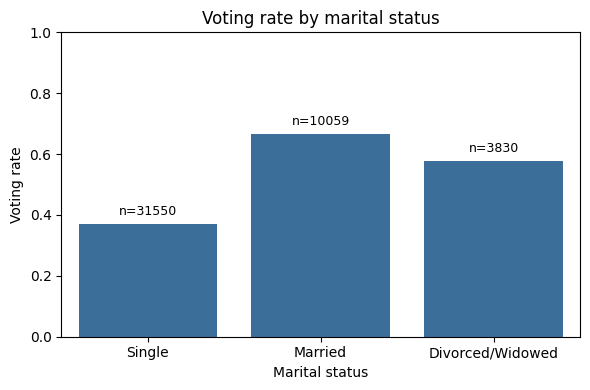

In [ ]:
# 3. 시각화
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=married_summary,
    x="married_clean",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Marital status")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by marital status")

# x축 라벨 가독성 개선
ax.set_xticklabels(["Single", "Married", "Divorced/Widowed"])

# 막대 끝 기준 n 표시
for patch, (_, row) in zip(ax.patches, married_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

##### married: 미혼인 경우 투표율이 비교적 낮음

#### 8. race

In [ ]:
# 1. race 요약 테이블
race_summary = (
    df_eda
    .groupby("race")
    .agg(voted_rate=("voted_bin","mean"), n=("voted_bin","size"))
    .reset_index()
    .sort_values("n", ascending=False)
)
race_summary

,race,voted_rate,n
6,White,0.504224,31248
1,Asian,0.295435,6834
5,Other,0.377598,4330
2,Black,0.402214,2168
4,Native American,0.412409,548
0,Arab,0.290598,351
3,Indigenous Australian,0.452830,53


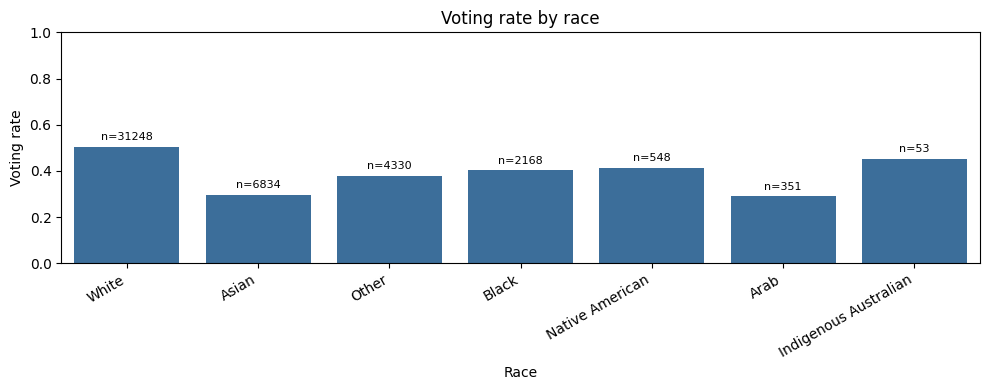

In [ ]:
# 2. 시각화
plt.figure(figsize=(10,4))
ax = sns.barplot(
    data=race_summary,
    x="race",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Race")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by race")

# x축 라벨 기울이기 (필수)
plt.xticks(rotation=30, ha="right")

# 막대 끝 기준 n 표시
for patch, (_, row) in zip(ax.patches, race_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

##### race: white, indigenous australian에서 투표율이 비교적 높음

#### 9. religion

In [ ]:
# 1. religion 요약테이블
religion_summary = (
    df_eda
    .groupby("religion")
    .agg(voted_rate=("voted_bin","mean"), n=("voted_bin","size"))
    .reset_index()
    .sort_values("n", ascending=False)
)
religion_summary

,religion,voted_rate,n
1,Atheist,0.427296,10192
0,Agnostic,0.457398,9624
3,Christian_Catholic,0.473488,6431
5,Christian_Other,0.460385,5137
6,Christian_Protestant,0.565333,4875
10,Other,0.417191,4770
7,Hindu,0.386984,1429
9,Muslim,0.312919,1192
2,Buddhist,0.378824,850
8,Jewish,0.550308,487


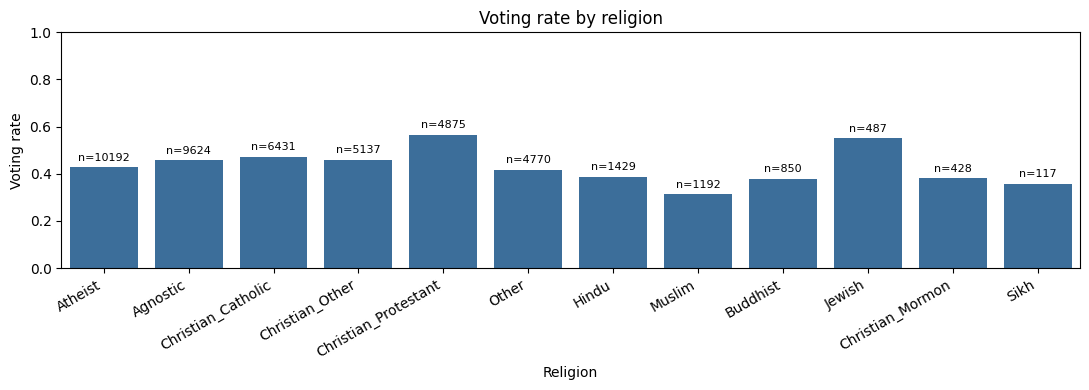

In [ ]:
# 2. 시각화
plt.figure(figsize=(11,4))
ax = sns.barplot(
    data=religion_summary,
    x="religion",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Religion")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by religion")

# x축 라벨 기울이기 (필수)
plt.xticks(rotation=30, ha="right")

# 막대 끝 기준 n 표시
for patch, (_, row) in zip(ax.patches, religion_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

#### 10. urban

In [ ]:
# 1. 전처리 (무응답 제외)
df_eda["urban_clean"] = df_eda["urban"].replace(0, np.nan)
df_eda["urban_clean"].value_counts(dropna=False)

urban_clean
2.0    18534
3.0    17767
1.0     8909
NaN      322
Name: count, dtype: int64

In [ ]:
# 2. urban별 투표율 요약 테이블
urban_summary = (
    df_eda
    .groupby("urban_clean")
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
    .sort_values("urban_clean")
)

overall_rate = df_eda["voted_bin"].mean()
urban_summary["delta_vs_overall"] = urban_summary["voted_rate"] - overall_rate

urban_summary


,urban_clean,voted_rate,n,delta_vs_overall
0,1.0,0.507128,8909,0.053952
1,2.0,0.458455,18534,0.005279
2,3.0,0.419598,17767,-0.033578


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/3656710370.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Rural", "Suburban", "Urban"])


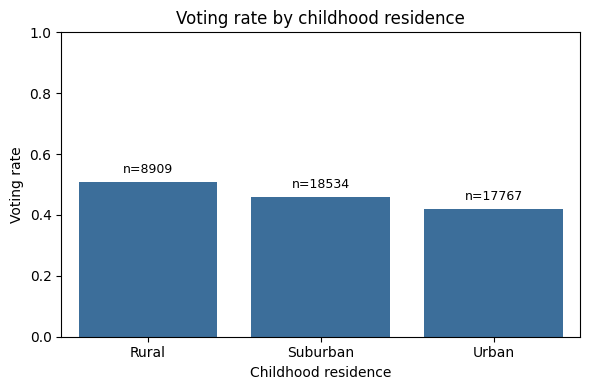

In [ ]:
# 3. 시각화 
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=urban_summary,
    x="urban_clean",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Childhood residence")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by childhood residence")

# x축 라벨 정리
ax.set_xticklabels(["Rural", "Suburban", "Urban"])

# 막대 끝 기준 n 표시
for patch, (_, row) in zip(ax.patches, urban_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


---------------

## 5. wr, wf

정상적인 응답자:

wr: Yes가 어느 정도 있음

wf: 거의 전부 No


문제 있는 응답자:

wr: Yes 많음

wf도 Yes

In [ ]:
# 실존 단어 인지 점수
df["wr_sum"] = df[[f"wr_{i:02d}" for i in range(1,14)]].sum(axis=1)

# 가짜 단어 착각 점수
df["wf_sum"] = df[[f"wf_{i:02d}" for i in range(1,4)]].sum(axis=1)

# 아는 건 안다고 하고, 모르는 건 모른다고 한 정도
df["word_credibility"] = df["wr_sum"] - df["wf_sum"]

df[["wr_sum", "wf_sum", "word_credibility"]].describe()


,wr_sum,wf_sum,word_credibility
count,45532.000000,45532.000000,45532.000000
mean,9.276443,0.361614,8.914829
std,2.365986,0.690377,2.293597
min,0.000000,0.000000,-3.000000
25%,8.000000,0.000000,8.000000
50%,9.000000,0.000000,9.000000
75%,11.000000,1.000000,10.000000
max,13.000000,3.000000,13.000000


In [ ]:
# 구간화
df["cred_bin"] = pd.cut(
    df["word_credibility"],
    bins=[-3, 1, 6, 13],   # 낮음 / 중간 / 높음 (경험적 기준)
    labels=["Low", "Mid", "High"]
)

In [ ]:
# 투표율 요약 테이블
cred_summary = (
    df
    .groupby("cred_bin")
    .agg(
        voted_rate=("voted_bin", "mean"),
        n=("voted_bin", "size")
    )
    .reset_index()
)

cred_summary


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/1237958354.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("cred_bin")


,cred_bin,voted_rate,n
0,Low,0.373973,730
1,Mid,0.324224,4025
2,High,0.467365,40769


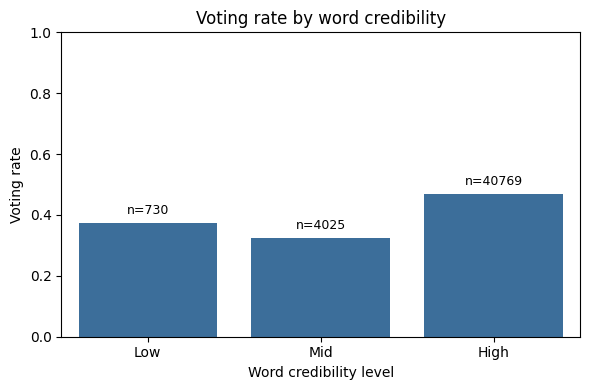

In [ ]:
# 시각화
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=cred_summary,
    x="cred_bin",
    y="voted_rate",
    color="#2c6faa"
)

ax.set_ylim(0, 1)
ax.set_xlabel("Word credibility level")
ax.set_ylabel("Voting rate")
ax.set_title("Voting rate by word credibility")

# n 표시
for patch, (_, row) in zip(ax.patches, cred_summary.iterrows()):
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.02,
        f'n={int(row["n"])}',
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


#### Wr/wf 따로 비교

In [ ]:
df["wr_bin"] = pd.cut(
    df["wr_sum"],
    bins=[-1, 4, 9, 13],
    labels=["Low", "Mid", "High"]
)

df.groupby("wr_bin").agg(
    voted_rate=("voted_bin","mean"),
    n=("voted_bin","size")
)

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_57966/1563712502.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("wr_bin").agg(


,voted_rate,n
wr_bin,,
Low,0.352555,2133
Mid,0.390199,21243
High,0.523244,22156


In [ ]:
df.groupby("wf_sum").agg(
    voted_rate=("voted_bin","mean"),
    n=("voted_bin","size")
)

,voted_rate,n
wf_sum,,
0,0.442544,33617
1,0.486445,8410
2,0.485366,2460
3,0.451675,1045
